In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

# 1. Data Manipulation
import pandas as pd
import numpy as np

#2. Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#3. Data Preprocessing and transformation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

# 4. Models
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor

# 5. Evaluation Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import os
import pipeline as p
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Get the current working directory
abspath = os.getcwd()

# Load the Feature Selected file
df = pd.read_csv(os.path.join(abspath, 'final_train.csv'))

In [5]:
df.dtypes

inspectionStartTime                                           object
year                                                           int64
odometer_reading                                               int64
ageing                                                         int64
engineTransmission_battery_value                              object
engineTransmission_engineoilLevelDipstick_value               object
engineTransmission_engineOil                                  object
engineTransmission_engine_value                               object
engineTransmission_exhaustSmoke_value                         object
engineTransmission_engineBlowByBackCompression_value          object
engineTransmission_battery_cc_value_0                         object
engineTransmission_battery_cc_value_1                         object
engineTransmission_engineOil_cc_value_0                       object
engineTransmission_engine_cc_value_0                          object
engineTransmission_engine_cc_value

<h2> 5.1 Data Pre-Processing</h2>

In [6]:
# We are performing Time based Splitting using inspectionStartTime feature
df['inspectionStartTime'] = pd.to_datetime(df['inspectionStartTime'])
df.sort_values(by = 'inspectionStartTime', inplace= True)

In [7]:
# Splitting the data into Dependent and Independent Variables
X = df.drop(columns=['rating_engineTransmission', 'inspectionStartTime']) # we no need start time as it was only used for time based splitting
y = df['rating_engineTransmission'].values

In [8]:
# Define the split point (e.g., 85% for training)
split_point = int(0.85 * len(df))

# Split into Train and CV sets
X_train = X[:split_point]
X_cv = X[split_point:]
y_train = y[:split_point]
y_cv = y[split_point:]

print("Total data points in training data: ", X_train.shape[0])
print("Total data points in cv data: ", X_cv.shape[0])

Total data points in training data:  17888
Total data points in cv data:  3157


<h2> 5.2 Data Standardization </h2

<h3> 5.2.1 StandardScaler for Numerical Data</h3>

In [9]:
# we have only one Numerical feature lets perform Standard Scaler
scaler = StandardScaler()
scaler.fit(pd.DataFrame(X_train[['odometer_reading', 'year', 'ageing']]))
pickle.dump(scaler, open('trained_models/scaler.pkl', 'wb'))


<h3> 5.2.1 One Hot Encoding for the categorical features </h3>

In [10]:
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns

# applying One Hot Encoding to categorical columns
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[categorical_cols])
pickle.dump(ohe, open('trained_models/ohe.pkl', 'wb'))

<h5> Transforming X_train and X_cv </h5>

In [11]:
# 1. X_train
train_num = scaler.transform(X_train[scaler.feature_names_in_])
train_cat = ohe.transform(X_train[ohe.feature_names_in_])

#2. X_cv
cv_num = scaler.transform(X_cv[scaler.feature_names_in_])
cv_cat = ohe.transform(X_cv[ohe.feature_names_in_])

# Storing the transformed data for model training and evaluation
X_tr = hstack((train_num, train_cat)).tocsr()
X_crv = hstack((cv_num, cv_cat)).tocsr()

In [12]:
print("Final Data matrix")
print("Train Data: ", X_tr.shape, y_train.shape)
print("CV Data: ", X_crv.shape, y_cv.shape)
print("="*100)

Final Data matrix
Train Data:  (17888, 102) (17888,)
CV Data:  (3157, 102) (3157,)


<h2> 6. Baseline mean model </h2
* This model has been made to set the benchmark

In [13]:
# Calculate the mean of the target variable from the training data
mean_target = np.mean(y_train)

# Predict the mean for all test samples
mean_predictions = np.full(shape=len(y_cv), fill_value=mean_target)

mse_mean_model = mean_squared_error(y_cv, mean_predictions)
print("Mean Squared Error of the Mean Model (Baseline):", mse_mean_model)

msle_mean_model = mean_squared_log_error(y_cv, mean_predictions)
print("Mean Squared Log Error of the Mean Model (Baseline):", msle_mean_model)

Mean Squared Error of the Mean Model (Baseline): 0.7137764717950748
Mean Squared Log Error of the Mean Model (Baseline): 0.053384059098799924


<h2> 7. Model Implementation </h2>

<h3> 7.1 Model 1: Linear Regression</h3>

Alpha Values =  [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
MLSE Train:  [0.03937344063657162, 0.03936941931745795, 0.03439652727085222, 0.03445143952901557, 0.03452610448251148, 0.035719172346893854, 0.04172639015010398, 0.054760015546061976, 0.05099943295061155, 0.05099943295061155]
MLSE Train:  [0.03763876717968864, 0.03763876717968864, 0.03379663440909875, 0.033974659758499864, 0.034326942978218616, 0.03588505635650719, 0.040337941244183904, 0.0530721256598967, 0.049454906622904006, 0.049454906622904006]
MSE Train:  [0.5113344141323792, 0.5112365831842576, 0.4904125670840787, 0.49062220483005364, 0.49408821556350624, 0.5109430903398927, 0.5137242844364938, 0.7452342352415027, 0.6522808586762076, 0.6522808586762076]
MSE Train:  [0.4971491922711435, 0.4971491922711435, 0.4892302819132087, 0.4885175799809946, 0.4930313588850174, 0.5171840354767184, 0.4989705416534685, 0.7300443458980045, 0.6407190370605005, 0.6407190370605005]


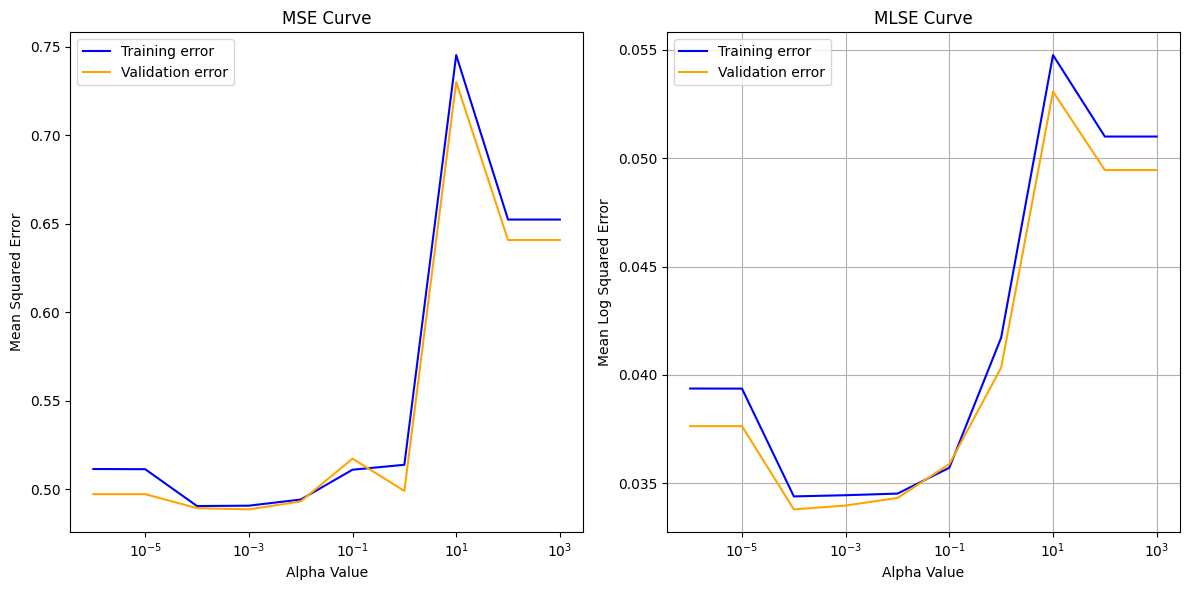

In [14]:
# Implementing Linear Regression

alpha = [10 ** x for x in range(-6, 4)] # hyperparam for SGD classifier.

# for storing the errors for both cv and train
mse_training_error_array = []
mse_cv_error_array=[]
mlse_training_error_array = []
mlse_cv_error_array=[]

for i in alpha:
    linear = SGDRegressor(alpha=i, penalty='l2', loss='squared_error', learning_rate= 'constant',random_state=42, max_iter= 2000)
    linear.fit(X_tr, y_train)
    # training Prediction
    training_predict_y = p.clipped(linear.predict(X_tr))
    # Storing MSE 
    mse_training_error_array.append(mean_squared_error(y_train, training_predict_y))
    # Storing MLSE
    mlse_training_error_array.append(mean_squared_log_error(y_train, training_predict_y))

    # cv Prediction
    cv_predict_y = p.clipped(linear.predict(X_crv))
    # Storing CV MSE
    mse_cv_error_array.append(mean_squared_error(y_cv, cv_predict_y))
    # Storing CV MLSE
    mlse_cv_error_array.append(mean_squared_log_error(y_cv, cv_predict_y))

print('Alpha Values = ', alpha)
print('MLSE Train: ', mlse_training_error_array)
print('MLSE Train: ', mlse_cv_error_array)
print("="*50)
print('MSE Train: ', mse_training_error_array)
print('MSE Train: ', mse_cv_error_array)

# Plot the error curve

# Set up the subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].plot(alpha, mse_training_error_array, label='Training error', color='blue')
axes[0].plot(alpha, mse_cv_error_array, label='Validation error', color='orange')
axes[0].set_xscale('log')
axes[0].set_title('MSE Curve')
axes[0].set_xlabel('Alpha Value')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()

axes[1].plot(alpha, mlse_training_error_array, label='Training error', color='blue')
axes[1].plot(alpha, mlse_cv_error_array, label='Validation error', color='orange')
axes[1].set_xscale('log')
axes[1].set_title('MLSE Curve')
axes[1].set_xlabel('Alpha Value')
axes[1].set_ylabel('Mean Log Squared Error')
axes[1].legend()
# Adjust layout for better spacing
plt.tight_layout()

plt.grid(True)
# Show the plots
plt.show()


Observations:
* At alpha = 0.001 both MLSE and MSE has less errors, and even the difference b/w Train and CV is minimal

In [15]:
#Train and save the model with best hyperparameter
best_alpha = 0.001
rgr = SGDRegressor(alpha=best_alpha, penalty='l2', loss='squared_error', learning_rate= 'constant',random_state=42, max_iter= 2000)
rgr.fit(X_tr, y_train)

tr_predict_y = p.clipped(rgr.predict(X_tr))
print('For values of best alpha = ', best_alpha, "The train log loss is:", mean_squared_error(y_train, tr_predict_y))
cv_predict_y = p.clipped(rgr.predict(X_crv))
print('For values of best alpha = ', best_alpha, "The test log loss is:", mean_squared_error(y_cv, cv_predict_y))
print("="*70)

print('For values of best alpha = ', best_alpha, "The train mean_squared_log_error is:", mean_squared_log_error(y_train, tr_predict_y))
print('For values of best alpha = ', best_alpha, "The test mean_squared_log_error is:", mean_squared_log_error(y_cv, cv_predict_y))

# Saving the Linear Model with best alpha
pickle.dump(rgr, open('trained_models/linear_regression.pkl', 'wb'))

For values of best alpha =  0.001 The train log loss is: 0.49062220483005364
For values of best alpha =  0.001 The test log loss is: 0.4885175799809946
For values of best alpha =  0.001 The train mean_squared_log_error is: 0.03445143952901557
For values of best alpha =  0.001 The test mean_squared_log_error is: 0.033974659758499864


<h3> 7.2 Model 2: Decision Tree</h3>

Max Depth =  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MLSE Train:  [0.034921729527601, 0.02895105861164464, 0.0278206409634479, 0.019747220823445027, 0.01641659516594705, 0.015871714476168194, 0.015580852465017381, 0.015314988966275964, 0.015217051106125548, 0.015201685228724851]
MLSE Train:  [0.03361525811338881, 0.02932877655811173, 0.02799675161838546, 0.020836380434663, 0.01815561409820718, 0.017652929030681438, 0.017329663476403218, 0.017019109456086447, 0.01700046032524619, 0.016931668990254157]
MSE Train:  [0.5544918381037567, 0.43516603309481217, 0.41161672629695883, 0.31563059033989266, 0.27723893112701253, 0.2684760733452594, 0.26361247763864043, 0.2593638193202147, 0.25798021019677997, 0.25732334525939177]
MSE Train:  [0.5412575229648401, 0.4419543870763383, 0.41487171365220143, 0.3272885650934431, 0.29743427304402914, 0.2917326575863161, 0.28737725688945204, 0.2819923978460564, 0.2824675324675325, 0.28072537218878685]


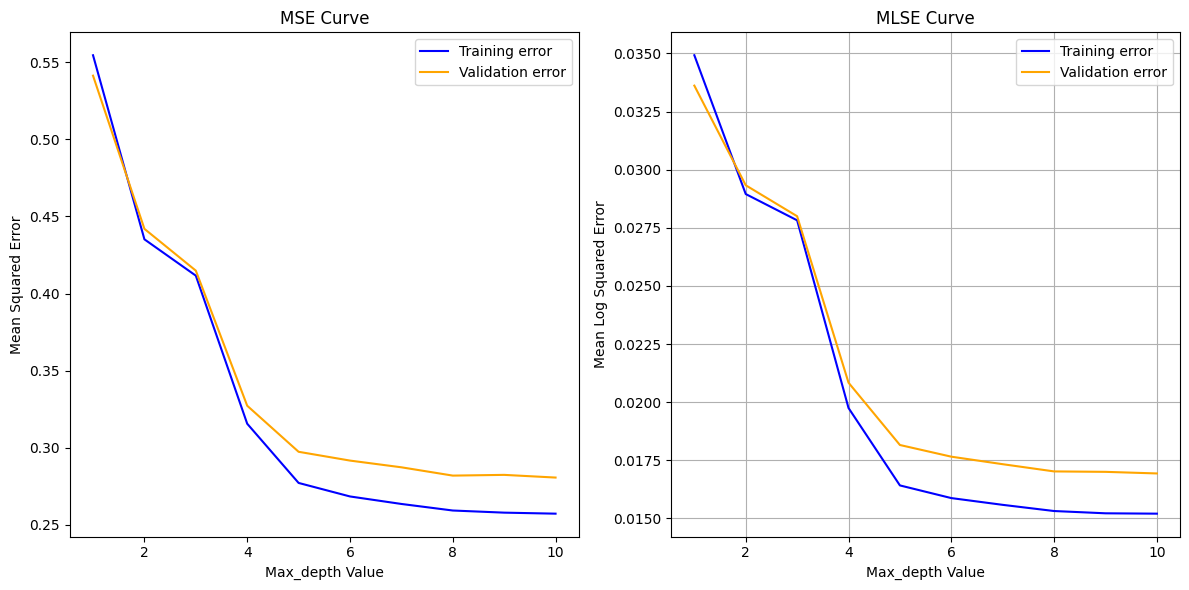

In [16]:
# Implementing Decision Tree

max_depth = range(1,11) # hyperparam for SGD classifier.

# for storing the errors for both cv and train
mse_training_error_array = []
mse_cv_error_array=[]
mlse_training_error_array = []
mlse_cv_error_array=[]

for i in max_depth:
    dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf= 100)
    dt.fit(X_tr, y_train)
    # training Prediction
    training_predict_y = p.clipped(dt.predict(X_tr))
    # Storing MSE 
    mse_training_error_array.append(mean_squared_error(y_train, training_predict_y))
    # Storing MLSE
    mlse_training_error_array.append(mean_squared_log_error(y_train, training_predict_y))

    # cv Prediction
    cv_predict_y = p.clipped(dt.predict(X_crv))
    # Storing CV MSE
    mse_cv_error_array.append(mean_squared_error(y_cv, cv_predict_y))
    # Storing CV MLSE
    mlse_cv_error_array.append(mean_squared_log_error(y_cv, cv_predict_y))

print('Max Depth = ', list(max_depth))
print('MLSE Train: ', mlse_training_error_array)
print('MLSE Train: ', mlse_cv_error_array)
print("="*50)
print('MSE Train: ', mse_training_error_array)
print('MSE Train: ', mse_cv_error_array)

# Plot the error curve

# Set up the subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

axes[0].plot(max_depth, mse_training_error_array, label='Training error', color='blue')
axes[0].plot(max_depth, mse_cv_error_array, label='Validation error', color='orange')
axes[0].set_title('MSE Curve')
axes[0].set_xlabel('Max_depth Value')
axes[0].set_ylabel('Mean Squared Error')
axes[0].legend()

axes[1].plot(max_depth, mlse_training_error_array, label='Training error', color='blue')
axes[1].plot(max_depth, mlse_cv_error_array, label='Validation error', color='orange')
axes[1].set_title('MLSE Curve')
axes[1].set_xlabel('Max_depth Value')
axes[1].set_ylabel('Mean Log Squared Error')
axes[1].legend()
# Adjust layout for better spacing
plt.tight_layout()

plt.grid(True)
# Show the plots
plt.show()


In [17]:
dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf= 100)
dt.fit(X_tr, y_train)

tr_predict_y = dt.predict(X_tr)
print("The train MSE is:", mean_squared_error(y_train, tr_predict_y))
cv_predict_y = dt.predict(X_crv)
print("The CV MSE is:", mean_squared_error(y_cv, cv_predict_y))

print("="*70)

print("The train MSLE is:", mean_squared_log_error(y_train, tr_predict_y))
print("The CV MSLE is:", mean_squared_log_error(y_cv, cv_predict_y))

# Saving the model with best max_depth
pickle.dump(dt, open('trained_models/decision_tree.pkl', 'wb'))

The train MSE is: 0.26240551024617115
The CV MSE is: 0.28107122065058276
The train MSLE is: 0.015731706197413757
The CV MSLE is: 0.01751060510139259


<h2> 8. Model Evaluation</h2>

<h3>8.1 Evaluating the Decision Tree Model performance</h3>

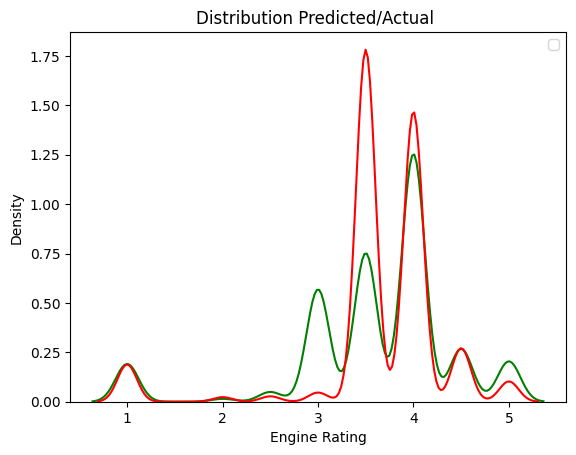

In [18]:
# Plotting distibution of the predicted and actual value
sns.kdeplot(y_train, color ='green')
sns.kdeplot(p.clipped(tr_predict_y), color = 'red')
plt.legend()
plt.xlabel('Engine Rating')
plt.title('Distribution Predicted/Actual ')
plt.show()

Observation:
* Areas of Improvement: While the model achieved a decent score overall, the predictors struggled to accurately predict instances where the rating was 3, as observed in the distribution of predictions.

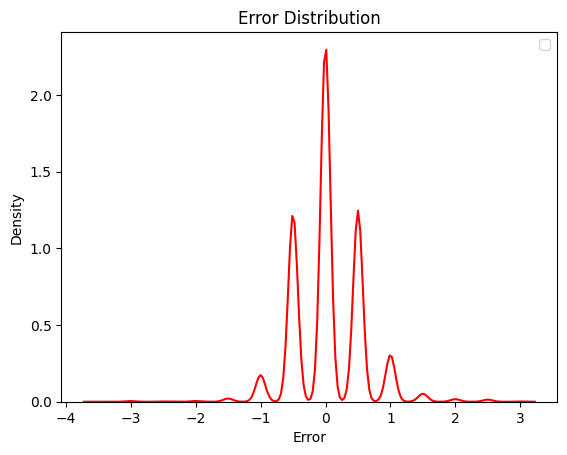

In [28]:
# Plotting distibution of the predicted and actual value
sns.kdeplot(p.clipped(tr_predict_y) - y_train, color = 'red')
plt.legend()
plt.xlabel('Error')
plt.title('Error Distribution')
plt.show()

Observations:
* The error is mostly distributed around 0, indicating the model's overall decent performance.
* However, there are some errors in the range of -1 to 1, which provides an opportunity to focus on improving the model's performance.

<h2> 9. 
Final Evaluation using Test data </h2>

In [20]:
# Reading the Test data 
test = pd.read_csv('test.csv')
# We will be using the pipeline modeule created to perform preprocessing, rearrangement etc
X_test = p.pre_processing(test)

<h4> Using Linear Regression to predict Test data </h4>

In [22]:
linear = pickle.load(open('trained_models/linear_regression.pkl', 'rb'))
lin_pre = linear.predict(X_test)
print("The MSE test: ",mean_squared_error(lin_pre, test['rating_engineTransmission'].values))
print("The MLSE test: ",mean_squared_log_error(lin_pre, test['rating_engineTransmission'].values))

The MSE test:  0.4690047519736459
The MLSE test:  0.031326680377327075


<h4> Using Decision Tree to predict <b> Test data <b></h4>

In [23]:
dst = pickle.load(open('trained_models/decision_tree.pkl', 'rb'))
dt_pr = dst.predict(X_test)
print("The MSE test: ",mean_squared_error(dt_pr, test['rating_engineTransmission'].values))
print("The MLSE test: ",mean_squared_log_error(dt_pr, test['rating_engineTransmission'].values))

The MSE test:  0.25500540468452254
The MLSE test:  0.01584403472890455


<h3>Summary</h3>

In [24]:
# storing the prediction MSE and MLSE
dt_train_mse = mean_squared_error(dt.predict(X_tr), y_train)
dt_cv_mse = mean_squared_error(dt.predict(X_crv), y_cv)
dt_test_mse = mean_squared_error(dt_pr, test['rating_engineTransmission'].values)

dt_train_mlse = mean_squared_log_error(dt.predict(X_tr), y_train)
dt_cv_mlse = mean_squared_log_error(dt.predict(X_crv), y_cv)
dt_test_mlse = mean_squared_log_error(dt_pr, test['rating_engineTransmission'].values)

In [25]:
pd.DataFrame({'Train': [dt_train_mse, dt_train_mlse],
'CV': [dt_cv_mse, dt_cv_mlse],
'Test': [dt_test_mse, dt_test_mlse]}, index = ['MSE', 'MLE'])

,Train,CV,Test
MSE,0.262406,0.281071,0.255005
MLE,0.015732,0.017511,0.015844
